# Pandas Practice EDA on Kaggle Bank Marking Dataset

## Step 1: Load the dataset

In [120]:
import pandas as pd

dataset_path = "../dataset/bank.csv"
pd_bank_df = pd.read_csv(dataset_path)

## Step 2: Data Profiling and Quality Check

### Step 2-1: Dataset Overview

#### Step 2-1-1: Inspect Schema and Data Types

In [121]:
pd_bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   date       11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


#### Step 2-1-2: Class Distribution

In [150]:
print(pd_bank_df.deposit.head())
print(pd_bank_df.deposit.value_counts())
print(pd_bank_df.deposit.value_counts(normalize=True))

0    yes
1    yes
2    yes
3    yes
4    yes
Name: deposit, dtype: object
deposit
no     5873
yes    5289
Name: count, dtype: int64
deposit
no     0.52616
yes    0.47384
Name: proportion, dtype: float64


#### Step 2-1-3: Missing Value Analysis

In [122]:
pd_bank_df.isna().sum()

# For those columns with missing values, further invoke a method to show ratio of missing values by pie chart or number

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
date         0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

### Step 2-2: Inspect Numerical Columns for Distribution

#### Step 2-2-0: Numerical Metrics
- Central Tendency & Variability
    - Mean vs Median: Large gap indicates skewness
    - Standard Deviation: High values may indicate volatility or heterogeneity
- Distribution Shape
    - Skewness:
        - Positive skew → long right tail 
        - Negative skew → long left tail 
    - Kurtosis:
        - High kurtosis → heavy tails, more extreme outliers.
        - Low kurtosis → light tails, more uniform spread.
- Outlier Detection
    - Z-score or ±3×std: Good for normal-ish distributions.
    - IQR method: Flag values outside [Q1 - 1.5×IQR, Q3 + 1.5×IQR].
    - Domain-specific thresholds: Regulatory or business rules (e.g. age > 120).
- Regulatory or Operational Flags
    - Threshold breaches: Are any values violating known limits?
    - Audit trails: Are outliers explainable by business events?

In [123]:
# Univariate Analysis for Numeric Features
from scipy.stats import skew, kurtosis

def summarize_numeric(df):
    # describe() works on numeric features only
    # skew and kurtosis works on all columns and requires additional filtering
    numeric_df = df.select_dtypes(include='number')
    desc = numeric_df.describe().T
    desc['iqr'] = desc['75%'] - desc['25%']
    desc['cv'] = desc['std'] / desc['mean']
    desc['skew'] = numeric_df.apply(skew)
    desc['kurtosis'] = numeric_df.apply(kurtosis)

    # Calculate mode for each numeric column
    all_modes = {}
    for col in numeric_df.columns:
        all_modes[col] = numeric_df[col].mode().tolist()

    mode_df = pd.DataFrame(all_modes, index=['mode']).T
    desc = desc.join(mode_df)

    return desc.round(2)

summarize_numeric(pd_bank_df)

,count,mean,std,min,25%,50%,75%,max,iqr,cv,skew,kurtosis,mode
age,11162.0,41.23,11.91,18.0,32.0,39.0,49.00,95.0,17.00,0.29,0.86,0.62,31
balance,11162.0,1528.54,3225.41,-6847.0,122.0,550.0,1708.00,81204.0,1586.00,2.11,8.22,126.80,0
date,11162.0,15.66,8.42,1.0,8.0,15.0,22.00,31.0,14.00,0.54,0.11,-1.06,20
duration,11162.0,371.99,347.13,2.0,138.0,255.0,496.00,3881.0,358.00,0.93,2.14,7.30,97
campaign,11162.0,2.51,2.72,1.0,1.0,2.0,3.00,63.0,2.00,1.09,5.54,57.36,1
pdays,11162.0,51.33,108.76,-1.0,-1.0,-1.0,20.75,854.0,21.75,2.12,2.45,6.83,-1
previous,11162.0,0.83,2.29,0.0,0.0,0.0,1.00,58.0,1.00,2.75,7.33,106.15,0


#### Step 2-2-1: Cross-Check by Distribution Visualization

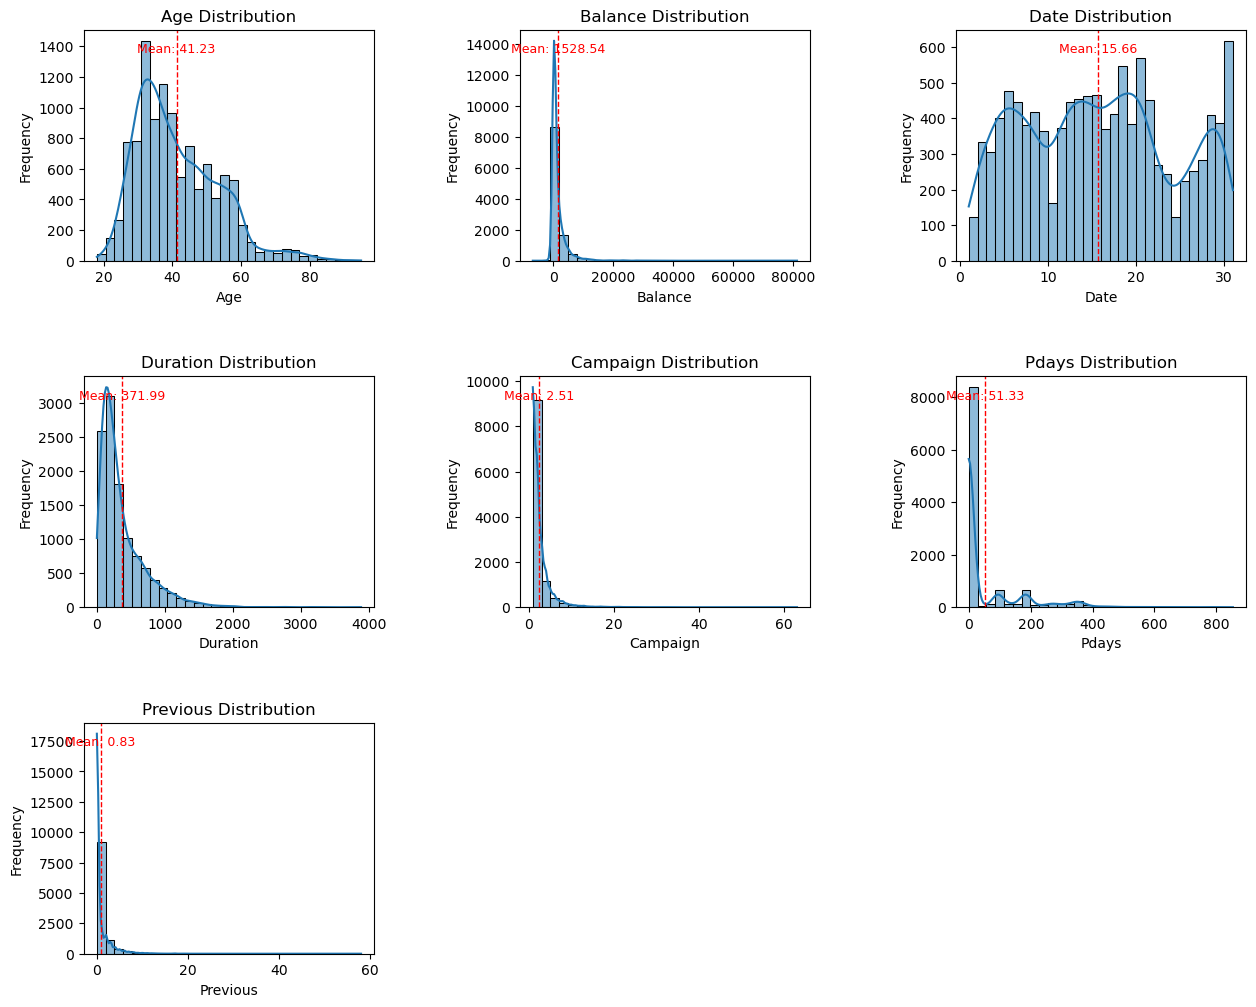

In [124]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plot_age_distribution(df, col_name):
#     sns.histplot(df[col_name], kde=True, bins=30)
#     plt.title(str(col_name.capitalize() + ' Distribution'))
#     plt.xlabel(col_name.capitalize())
#     plt.ylabel('Frequency')
#     plt.show()

# for num_col in pd_bank_df.describe().T.index:
#     plot_age_distribution(pd_bank_df, num_col)

import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_numeric_distributions(df, columns, figs_per_row=3, wspace=0.5, hspace=0.5):
    total = len(columns)
    rows = math.ceil(total / figs_per_row)
    fig, axes = plt.subplots(rows, figs_per_row, figsize=(5 * figs_per_row, 4 * rows))

    # Flatten axes for easy indexing
    axes = axes.flatten() if total > 1 else [axes]

    for i, col in enumerate(columns):
        sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
        mean_val = df[col].mean()
        axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1)
        axes[i].text(mean_val, axes[i].get_ylim()[1]*0.9,
                     f'Mean: {mean_val:.2f}', color='red', ha='center', fontsize=9)
        axes[i].set_title(f'{col.capitalize()} Distribution')
        axes[i].set_xlabel(col.capitalize())
        axes[i].set_ylabel('Frequency')

    # Hide unused subplots in the last row
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # plt.tight_layout()
    # Adjust spacing between plots
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()

plot_numeric_distributions(pd_bank_df, pd_bank_df.select_dtypes(include='number').columns.tolist(), 3, 0.5, 0.5)

#### Step 2-2-2: Count on Outliers by Range(Q1-1.5*IQR & Q3+1.5*IQR since non-normal distribution)

In [125]:
def count_outliers_std(df):
    numeric_df = df.select_dtypes(include='number')
    total_rows = len(numeric_df)
    summary = {}

    for col in numeric_df.columns:
        q1 = numeric_df[col].quantile(0.25)
        q3 = numeric_df[col].quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        mask = (numeric_df[col] < lower) | (numeric_df[col] > upper)
        count = mask.sum()
        percent = round((count / total_rows) * 100, 2)
        summary[col] = {'outlier_count': count, 'outlier_pct': percent}

    return pd.DataFrame.from_dict(summary, orient='index')

count_outliers_std(pd_bank_df)

,outlier_count,outlier_pct
age,171,1.53
balance,1055,9.45
date,0,0.00
duration,636,5.70
campaign,601,5.38
pdays,2750,24.64
previous,1258,11.27


#### Step 2-2-3: Display Box Plot for Numeric Features

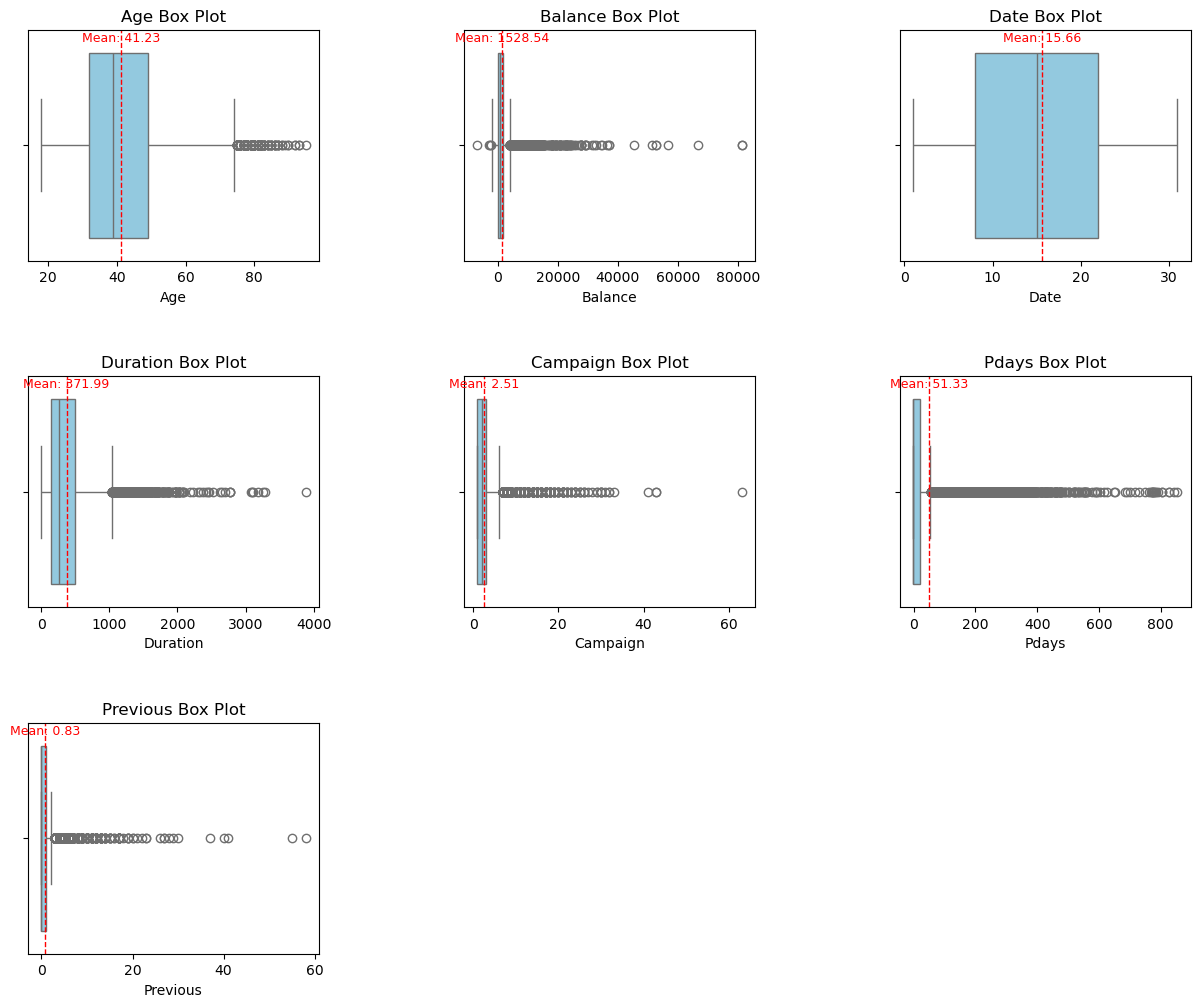

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_boxplots(df, columns, max_figs_per_row=3, wspace=0.4, hspace=0.5, show_mean=True):
    total = len(columns)
    rows = math.ceil(total / max_figs_per_row)
    fig, axes = plt.subplots(rows, max_figs_per_row, figsize=(5 * max_figs_per_row, 4 * rows))
    axes = axes.flatten() if total > 1 else [axes]

    for i, col in enumerate(columns):
        sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
        axes[i].set_title(f'{col.capitalize()} Box Plot')
        axes[i].set_xlabel(col.capitalize())

        if show_mean:
            mean_val = df[col].mean()
            axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1)
            axes[i].text(mean_val, axes[i].get_ylim()[1]*0.9,
                         f'Mean: {mean_val:.2f}', color='red', ha='center', fontsize=9)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()

plot_boxplots(pd_bank_df, pd_bank_df.select_dtypes(include='number').columns.tolist(), 3, 0.5, 0.5, True)

In [127]:
print(f"age_above_80: {(pd_bank_df['age'] > 80).sum()},\n"
      f"age_above_90: {(pd_bank_df['age'] > 90).sum()},\n"
      f"age_below_18: {(pd_bank_df['age'] < 18).sum()}")

age_above_80: 55,
age_above_90: 5,
age_below_18: 0


### Step 2-3: Inspect Categorical Type Columns for Distinct Values

#### Step 2-3-0: Categorical Metrics
- High Cardinality
- Dominant Category
- Meaningless Value
- Temporal Drift
- Encoding Inconsistency
- Semantic Redundancy

#### Step 2-3-1: Identify Categorical Type and Conversion

In [128]:
# General method to quickly filter category-like columns with high dimensional features set
# Note: boolean type columns would be included and need separate handling further
def suggest_category(df, threshold_num=10, threshold_pct=0.05):
    # Identify categorical columns
    obj_cols = df.select_dtypes(include=['object']).columns
    suggested_cols = []
    for col in obj_cols:
        if df[col].nunique() < threshold_num or df[col].value_counts(normalize=True).max() < threshold_pct:
            suggested_cols.append(col)
    return suggested_cols

# General method to quickly filter boolean-like columns
boolean_value = [0, 1, 'True', 'False', True, False]
def suggest_boolean(df, boolean_value):
    obj_cols = df.select_dtypes(include=['object']).columns
    suggested_cols = []
    for col in obj_cols:
        if df[col].nunique() == 2 and set(df[col].dropna().unique()).issubset(boolean_value):
            suggested_cols.append(col)
    return suggested_cols

# Manually specify categorical columns in dataset
cat_col = {'bank_marketing': ['job', 'marital', 'education', 'month', 'contact', 'poutcome']}

# Convert specified columns to category dtype
def convert_to_category(df, columns):
    for col in columns:
        df[col] = df[col].astype('category')
    return df

pd_bank_df = convert_to_category(pd_bank_df, cat_col['bank_marketing'])

# education column is ordinal
edu_order = ['unknown','primary', 'secondary', 'tertiary']
pd_bank_df.education = pd.Categorical(pd_bank_df.education, categories=edu_order, ordered=True)

# pd_bank_df.education.value_counts()


#### Step 2-3-2: Frequency Statistics

In [138]:
def frequency_summary(df, col):
    # Frequency statistics
    freq = df[col].value_counts(dropna=False)

    # Coverage statistics 
    # coverage = df[col].notna().mean()

    # Percentage statistics
    pct = (df[col].value_counts(normalize=True, dropna=False) * 100).round(2)
    return pd.DataFrame({ 'frequency': freq, 'percentage': pct})

for col in pd_bank_df.select_dtypes(include='category').columns:
    print(frequency_summary(pd_bank_df, col))

               frequency  percentage
job                                 
management          2566       22.99
blue-collar         1944       17.42
technician          1823       16.33
admin.              1334       11.95
services             923        8.27
retired              778        6.97
self-employed        405        3.63
student              360        3.23
unemployed           357        3.20
entrepreneur         328        2.94
housemaid            274        2.45
unknown               70        0.63
          frequency  percentage
marital                        
married        6351       56.90
single         3518       31.52
divorced       1293       11.58
           frequency  percentage
education                       
secondary       5476       49.06
tertiary        3689       33.05
primary         1500       13.44
unknown          497        4.45
           frequency  percentage
contact                         
cellular        8042       72.05
unknown         2346     

#### Step 2-3-3: Frequency Visualization

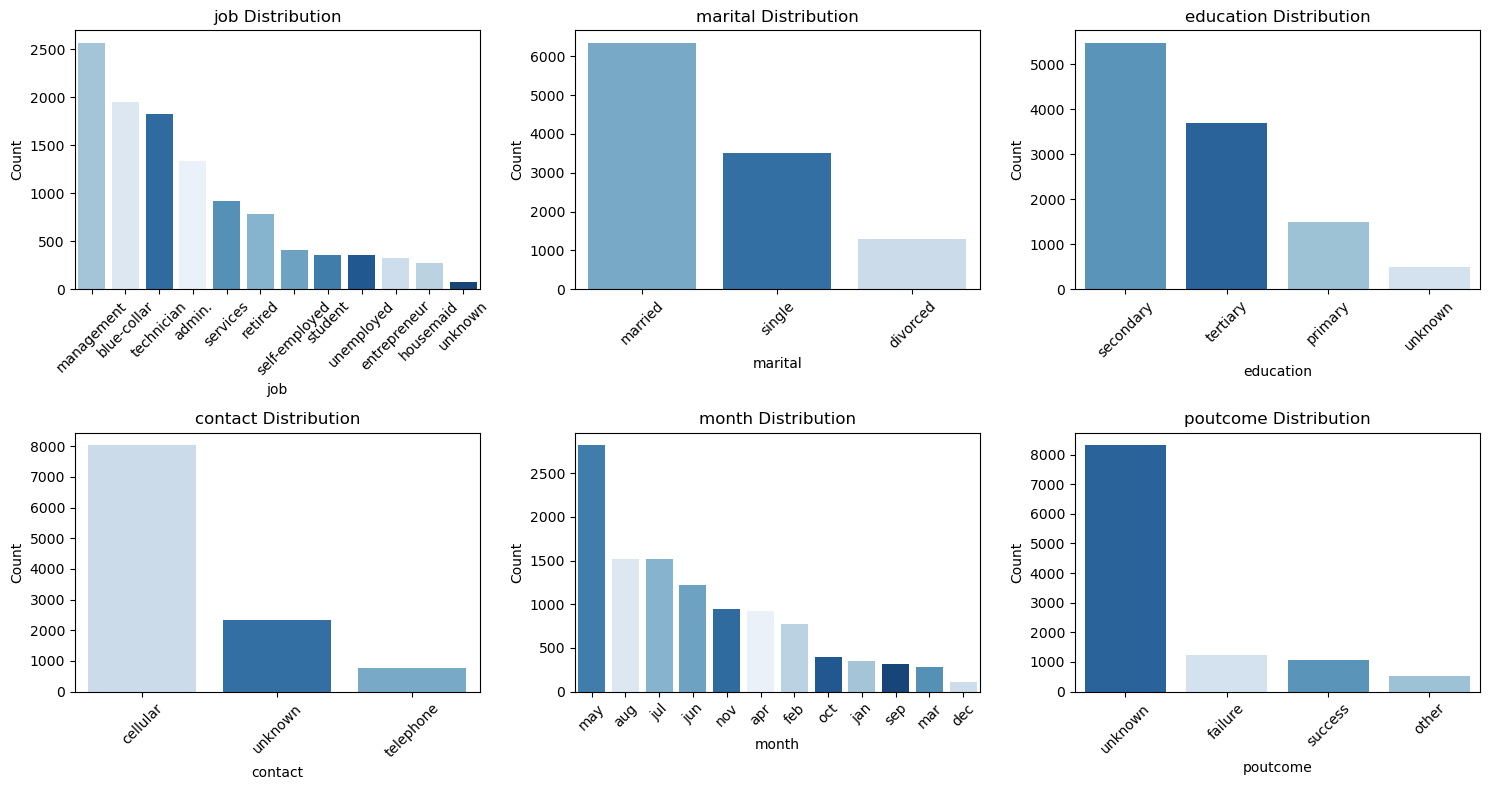

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_categorical_distributions(df, columns, max_figs_per_row=3, wspace=0.4, hspace=0.5, rotate_xticks=True):
    total = len(columns)
    rows = math.ceil(total / max_figs_per_row)
    fig, axes = plt.subplots(rows, max_figs_per_row, figsize=(5 * max_figs_per_row, 4 * rows))
    axes = axes.flatten() if total > 1 else [axes]

    for i, col in enumerate(columns):
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i], palette='Blues', hue=col, legend=False)
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        if rotate_xticks:
            axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.tight_layout()
    plt.show()

# def plot_category_distribution(df, col):
#     sns.countplot(data=df, x=col, order=df[col].value_counts().index)
#     plt.xticks(rotation=45)
#     plt.title(f'{col} Distribution')
#     plt.show()
# for col in pd_bank_df.select_dtypes(include='category').columns:
#     plot_category_distribution(pd_bank_df, col)

plot_categorical_distributions(pd_bank_df, pd_bank_df.select_dtypes(include='category').columns.tolist(), 3, 0.5, 0.5)


#### Step 2-3-4: Target Association

In [131]:
# A quick view of target variable distribution across categories without categorical count
# def cross_tab_target(df, cat_col, target_col='deposit'):
#     return pd.crosstab(df[cat_col], df[target_col], normalize='index')

# for col in pd_bank_df.select_dtypes(include='category').columns:
#     print(cross_tab_target(pd_bank_df, col).round(2))

#### Step 2-3-5: Target Association Visualization

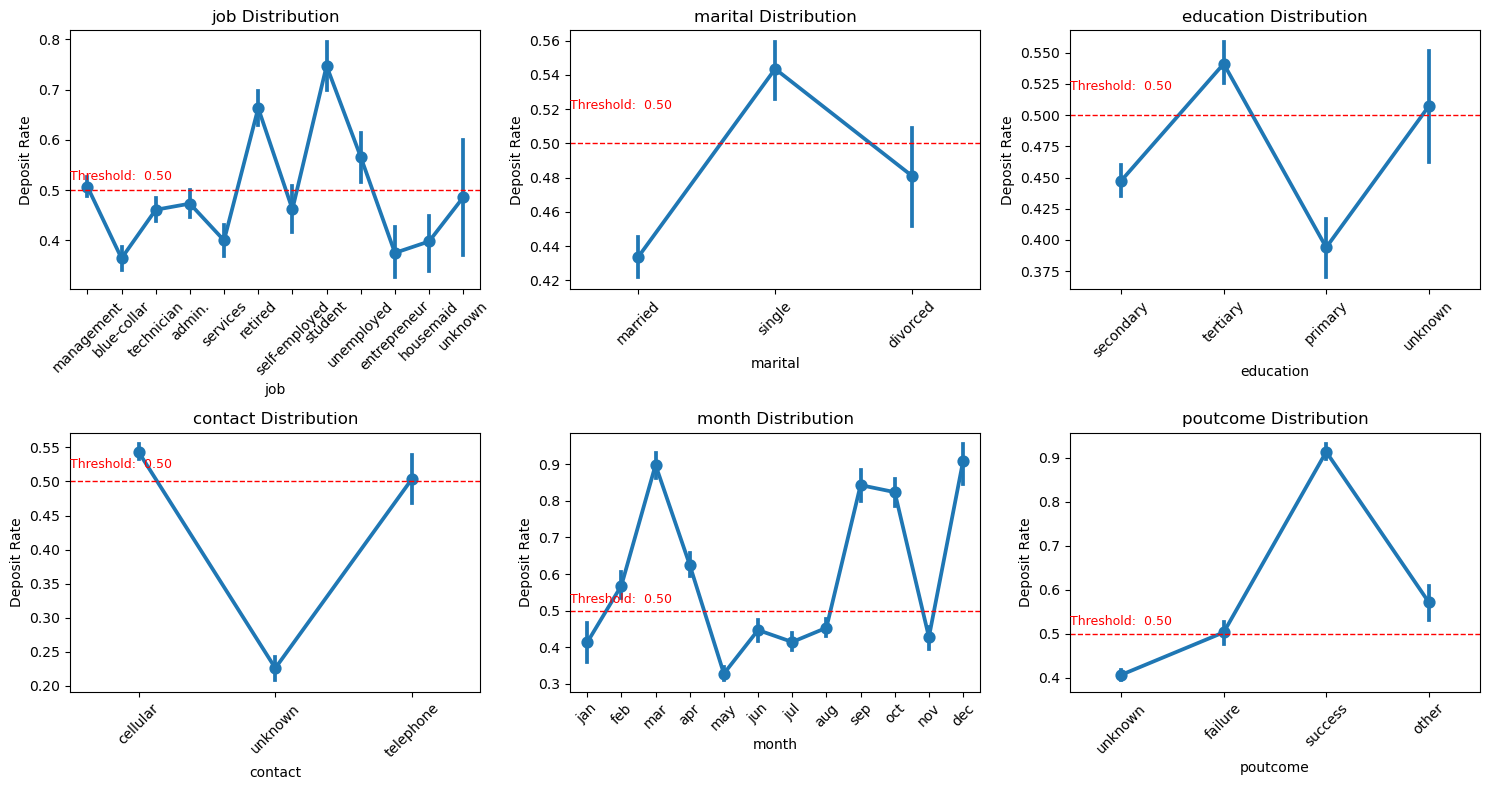

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

def plot_target_association_grid(df, cat_cols, target_col='deposit', 
                                 max_figs_per_row=3, wspace=0.4, hspace=0.5, 
                                 rotate_xticks=True, threshold=0.5):
    # Map target value from 'yes/no' to 1/0
    df_temp = df.copy()
    df_temp[target_col] = df_temp[target_col].map({'yes': 1, 'no': 0})

    # Create subplots
    total = len(cat_cols)
    rows = math.ceil(total / max_figs_per_row)
    fig, axes = plt.subplots(rows, max_figs_per_row, figsize=(5 * max_figs_per_row, 4 * rows))
    axes = axes.flatten() if total > 1 else [axes]

    # Set random seed for reproducibility
    np.random.seed(42)

    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for i, col in enumerate(cat_cols):
        order_by = month_order if col == 'month' else df_temp[col].value_counts().index

        sns.pointplot(data=df_temp, x=col, y=target_col,
                estimator='mean', order=order_by,
                ax=axes[i])

        axes[i].axhline(threshold, color='red', linestyle='--', linewidth=1)
        axes[i].text(-0.5, threshold + 0.02, f"Threshold: {threshold: .2f}", color='red', fontsize=9)

        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Deposit Rate')
        if rotate_xticks:
            axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.tight_layout()
    plt.show()

plot_target_association_grid(pd_bank_df, pd_bank_df.select_dtypes(include='category').columns.tolist())

# def plot_stacked_bar(df, cat_col='job', target_col='deposit'):
#     ctab = pd.crosstab(df[cat_col], df[target_col], normalize='index')
#     colors = ['#1f77b4', '#ff7f0e']
#     ctab.plot(kind='bar', stacked=True, figsize=(6, 4), color=colors)
#     plt.legend(title=target_col, loc='upper right', bbox_to_anchor=(1.2, 1))
#     plt.title(f'{cat_col} vs {target_col} (Stacked Proportions)')
#     plt.ylabel('Proportion')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

# plot_stacked_bar(pd_bank_df, 'job', 'deposit')

# def plot_target_heatmap(df, cat_col='job', target_col='deposit'):
#     ctab = pd.crosstab(df[cat_col], df[target_col], normalize='index')
#     sns.heatmap(ctab, annot=True, cmap='Reds', fmt='.2f')
#     plt.title(f'{cat_col} vs {target_col} (Proportion Heatmap)')
#     plt.ylabel(cat_col)
#     plt.xlabel(target_col)
#     plt.tight_layout()
#     plt.show()

# plot_target_heatmap(pd_bank_df, 'job', 'deposit')

### Step 2-4: Inspect Boolean Type Columns for Proportional Visualization

#### Step 2-4-0: Boolean Metrics
- Value distribution
- Class Imbalance

#### Step 2-4-1: Data Type Conversion

In [133]:
def convert_to_boolean(df, cols):
    for col in cols:
        df[col] = df[col].map({'yes': True, 'no': False})
        df[col] = df[col].astype('boolean')  # Convert to boolean dtype
    return df

bool_col = {'bank_marketing': ['default', 'housing', 'loan']}
pd_bank_df = convert_to_boolean(pd_bank_df, bool_col['bank_marketing'])

,default,housing,loan
0,False,True,False
1,False,False,False
2,False,True,False
3,False,True,False
4,False,False,False


#### Step 2-4-2: Value Distribution

In [139]:
for col in pd_bank_df.select_dtypes(include='boolean').columns:
    print(frequency_summary(pd_bank_df, col))

         frequency  percentage
default                       
False        10994       98.49
True           168        1.51
         frequency  percentage
housing                       
False         5881       52.69
True          5281       47.31
       frequency  percentage
loan                        
False       9702       86.92
True        1460       13.08


#### Step 2-4-3: Value Visualization

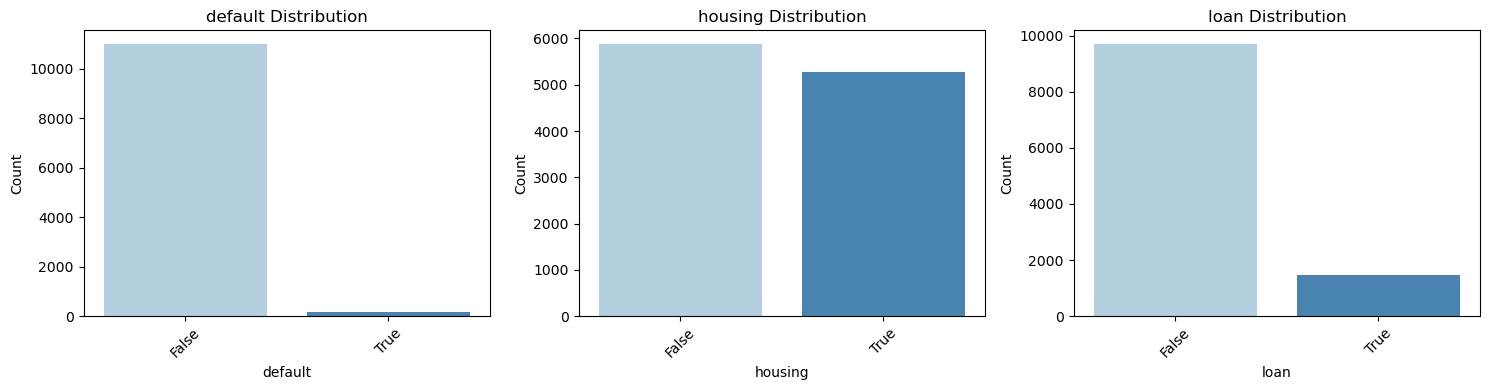

In [141]:
plot_categorical_distributions(pd_bank_df, pd_bank_df.select_dtypes(include='boolean').columns.tolist(), 3, 0.5, 0.5)

#### Step 2-4-4: Target Association Visualization

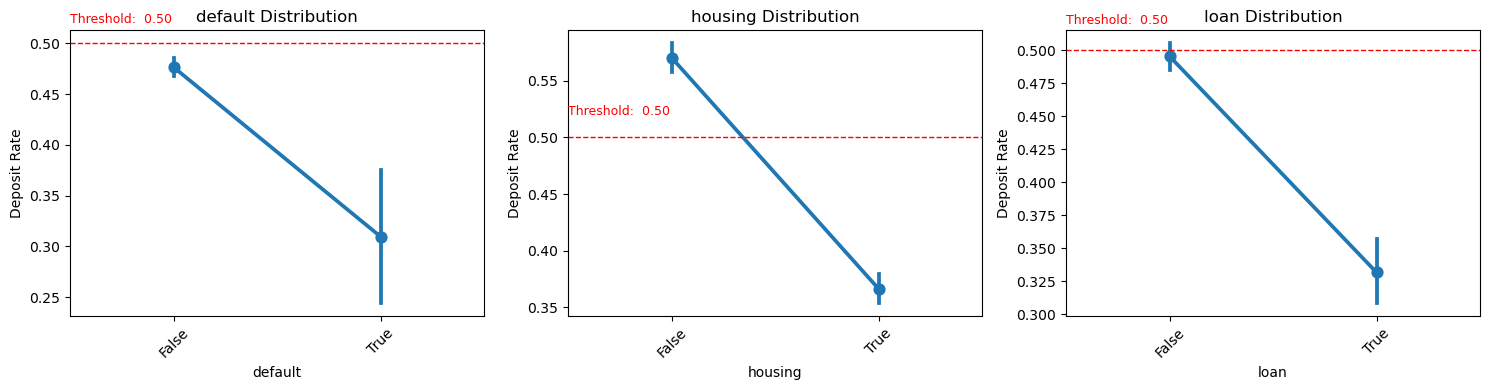

In [143]:
plot_target_association_grid(pd_bank_df, pd_bank_df.select_dtypes(include='boolean').columns.tolist())